In [25]:
# Import packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import sys
sys.path.insert(0, "../../")
register_matplotlib_converters()
import scipy


# Import modules from dynamic neural network
from dynamic_neural_networks.utils import *
from dynamic_neural_networks.transformations.helper_functions import *
from dynamic_neural_networks.transformations.sorted_real_schur_forms import *
from dynamic_neural_networks.model.dnn import *
from dynamic_neural_networks.model.state_space_model import *
from dynamic_neural_networks.utils.helper_functions import *
from dynamic_neural_networks.data.diffusion_equation_2d import *
from sklearn.metrics import root_mean_squared_error

expensive_asserts = False

In [ ]:
# Load the .mat file
#A = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['A'])
#B = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['B'])
#C = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['C'])

data_path = '../data/sys_id/' 
#timesteps = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['t'])[0]
#u_test = np.asarray(scipy.io.loadmat(data_path + '/ssm_data_500.mat')['U'])
#y_test = np.asarray(scipy.io.loadmat(data_path + '/sys_id_data.mat')['Y'])

# Load data from SSM trained with Adam

io_data = np.load(data_path + 'adam_data_500.npz')
# Access the matrices by their names
u_test = io_data['U']
y_test = io_data['Y']

# Load the matrices from the saved file
loaded_data = np.load(data_path + 'ssm_adam_500.npz')
# Access the matrices by their names
A = loaded_data['A']
B = loaded_data['B']
C = loaded_data['C']
D = loaded_data['D']


timesteps = np.arange(0,5,0.01)

In [27]:
print(np.shape(A), np.shape(B), np.shape(C))
print(np.shape(u_test))
print(np.shape(timesteps))

(10, 10) (10, 10) (10, 10)
(500, 10)
(500,)


In [28]:
# Problem setup
# Dimensions of the LTI system
# Dimensions of the LTI system
d_in = 10  # Input dimension  (<-> Source term: Heat source/sink at grid points)
d_state = 10  # State dimension  (<-> Temperature)
d_out = 10  # Output dimension (<-> Temperature (state = output))
ssm_dim = [d_state, d_in, d_out]  # Dimensions of the state-space model


# Set initial state
x_0 = np.zeros((d_state,))

# Timesteps
D = np.zeros((d_out, d_in)) 
ssm = state_space_model(A, B, C, D)

# Method to interpolate the input function within each time-step
u_interp = "piecewise_constant"  # 'piecewise_constant', 'piecewise_linear', 'sample'

# Set u(t)
u = u_test

# Compute u'(t) using first-order finite differences
du_dt = np.zeros((len(timesteps), d_in))
for i in range(0, d_in):
    du_dt[i] = (u[i + 1] - u[i]) / (timesteps[i + 1] - timesteps[i])
inputs = [u, du_dt]

In [29]:
# Dynamic Neural Network Parameters
n_clusters = 7 # Number of clusters of close eigenvalues
outer_loop = "timesteps"  # 'neurons', 'timesteps'
ode_solver_rel_tol = 1e-10  # relative tolerance for ODE solver
ode_solver_abs_tol = 1e-10  # absolute tolerance for ODE solver
clustering_alg = KMeans(
    n_clusters=n_clusters, random_state=0, n_init="auto"
)  # Clustering algorithm
params = forward_pass_parameters(
    outer_loop=outer_loop,
    ssm_input_interpolation=u_interp,
    solver_routine="solve_ivp",
    ode_solver_params=ode_solver_parameters(
        atol=ode_solver_abs_tol, rtol=ode_solver_rel_tol, ode_solver="DOP853"
    ),
)  # Parameters concerning forward pass of a DyNN

c:\Users\chinm\miniconda3\envs\dynn\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


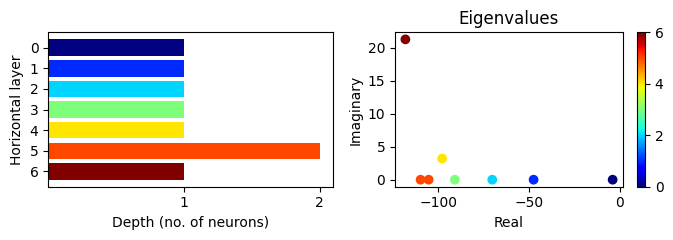

Condition number of the transformation matrix =  12.627066785348495


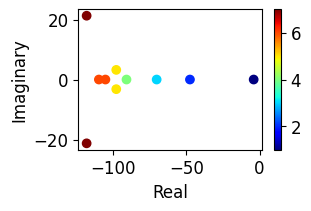

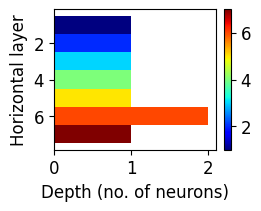

In [30]:
# Initialize the dynamic neural network
dynn = dynamic_neural_network(ssm=ssm)

# Simulate the LTI system using a dynamic neural network
dynn.fit(clustering_alg, verbose=0, show_plots=True, init_cond=x_0)

# Condition number of the transformation matrix
print("Condition number of the transformation matrix = ", dynn.cond_num)

# Plot eigenvalue clusters and DyNN architecture
dynn.plot_architecture(figname="sys_id", fig_size_1=(3, 2), fig_size_2=(2.5, 2), fontsize = 12, color_bar=True, sort_evals=False)

In [31]:
# Perform forward pass and compute output
y_dynn = dynn.predict(inputs, timesteps, params)


In [32]:
# Simulate the LTI system using python routine solve_ivp
y_solve_ivp, nfe_solver = numerical_simulation_ivp_solve(
    ssm,
    inputs,
    timesteps,
    u_interp,
    outer_loop,
    rtol=ode_solver_rel_tol,
    atol=ode_solver_abs_tol,
    init_cond=x_0
)

In [33]:
# Error compared to the numerical solver
abs_err_solve_ivp = abs(y_dynn - y_solve_ivp)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_solve_ivp))

abs_err_true = abs(y_dynn - y_test)
print("Max absolute error (DyNN and solver:solve_ivp) :", np.amax(abs_err_true))

print( np.sqrt(np.sum(np.power((y_dynn - y_test),2))))


print(root_mean_squared_error(y_dynn, y_test))
"""
0.038398980
0.35937776069497424
0.004980513833598028
"""

Max absolute error (DyNN and solver:solve_ivp) : 1.4117336639973832e-09
Max absolute error (DyNN and solver:solve_ivp) : 0.034916220059557565
0.5753568442028358
0.008033302176448808


'\n0.038398980\n0.35937776069497424\n0.004980513833598028\n'

C:\Users\chinm\AppData\Local\Temp\ipykernel_6424\2620669545.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


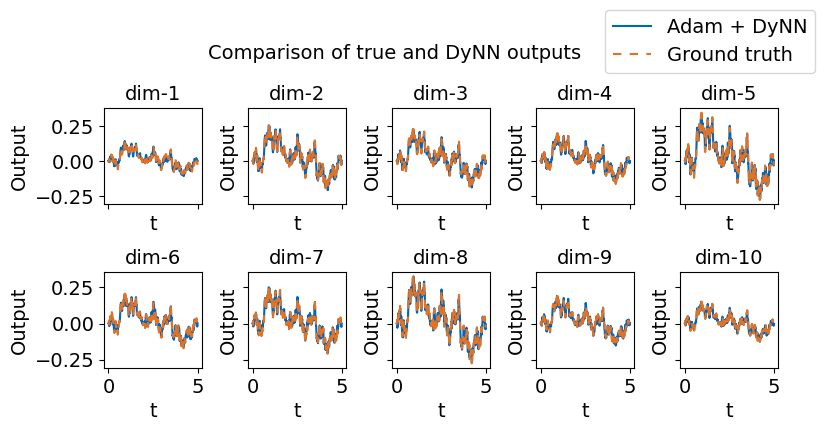

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fontsize=14
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex='col', sharey='row',constrained_layout='True')

# Loop through the axes and plot data
for i, ax in enumerate(axes.flat):
    ax.plot(timesteps, y_dynn[:, i], label='Adam + DyNN', color="#0065bd")
    ax.plot(timesteps, y_test[:, i],  label='Ground truth', 
            color="#e37222", linestyle='--', dashes=(4,4))
    ax.set_title(f"dim-{i+1}", fontsize = fontsize) 
    ax.set_ylabel(f"Output", fontsize = fontsize)
    ax.set_xlabel('t', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1, 
        bbox_to_anchor=(0.75, 1.09), fontsize=fontsize)

plt.suptitle("Comparison of true and DyNN outputs", fontsize=fontsize)
fig.tight_layout()
plt.savefig('adam_dynn.png')
plt.show()


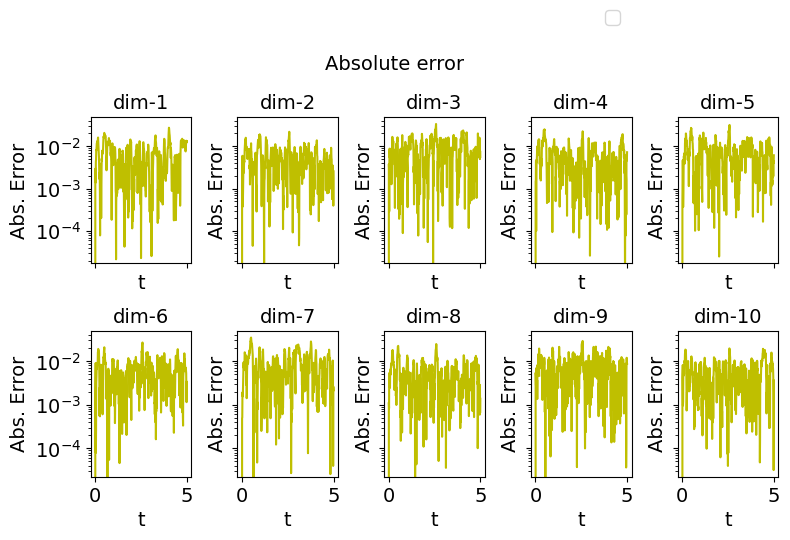

In [35]:
import matplotlib.pyplot as plt
import numpy as np

fontsize=14
fig, axes = plt.subplots(2, 5, figsize=(8, 5), sharex='col', sharey='row')

# Loop through the axes and plot data
for i, ax in enumerate(axes.flat):
    ax.semilogy(timesteps, np.abs(y_dynn[:, i] - y_test[:, i]), color="y")
    ax.set_title(f"dim-{i+1}", fontsize = fontsize) 
    ax.set_ylabel(f"Abs. Error", fontsize = fontsize)
    ax.set_xlabel('t', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=1, 
        bbox_to_anchor=(0.75, 1.09), fontsize=fontsize)

plt.suptitle("Absolute error", fontsize=fontsize)
fig.tight_layout()
plt.savefig('sys_id_error.pdf')
plt.show()
